In [1]:
# !pip install seaborn

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re


from IPython.display import Image
from IPython.core.display import HTML 
%matplotlib inline

Работа с текстом - это одна из тех вещей, с которыми приходится сталкиваться каждому дата саентисту. Одна из самых популярных задач, свзяанных с текстом - классификация. Например, классифицировать email сообщения на наличие спама в них или неменее популярная постановка задачи - классфицировать репорты пользователей о продукте на негативные и положительные. 

Сейчас на [kaggle](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge) как раз проходит соревнование связанное с класфикацией текстов по степени оскорбления в них. Метрика - площадь под roc-auc кривой

На данном семинаре мы попробуем наиболее простой подход - сделаем из текста tf-idf матрицу и обучим несколько моделей для решения данной задачи. 

Однако, прежде, чем обучать модели давайте посмотрим на данные:

In [3]:
x_train = pd.read_csv('./toxic/input/new/train.csv')
x_test = pd.read_csv('./toxic/input/new/test.csv')

In [4]:
x_train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


Проверим есть ли в данных пропущенные значения:

In [5]:
print('Кол-во пропущенных значений в train: ', np.sum(x_train.comment_text.isnull()))
print('Кол-во пропущенных значений в test: ', np.sum(x_test.comment_text.isnull()))

Кол-во пропущенных значений в train:  0
Кол-во пропущенных значений в test:  0


Отлично, пропущенных значений нет, тогда самое время посмотреть на баланс классов:

In [6]:
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

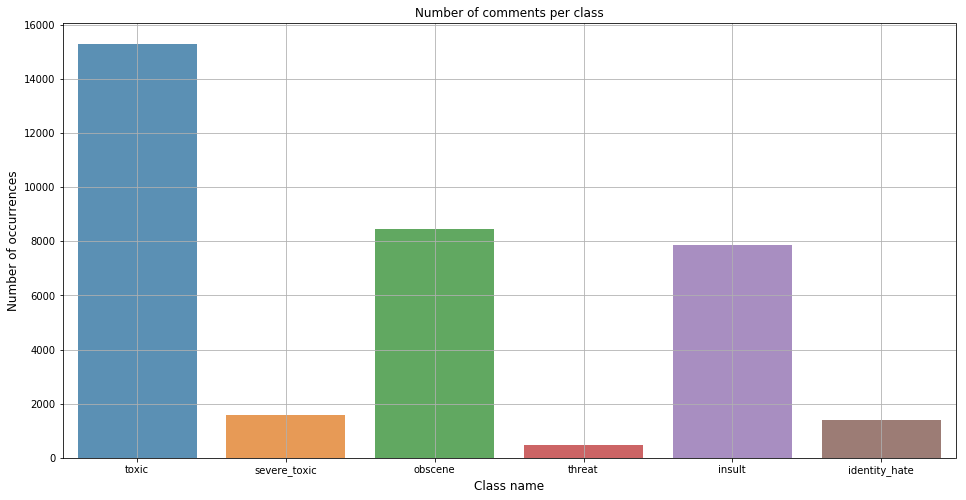

In [7]:
temp = x_train.loc[:,list_classes].sum()
plt.figure(figsize=(16, 8))
sns.barplot(temp.index, temp.values, alpha=0.8)
plt.title('Number of comments per class')
plt.ylabel('Number of occurrences', fontsize=12)
plt.xlabel('Class name', fontsize=12)
plt.grid(True)
plt.show()

Видно, что классы не сбалансированы, возможно с этим нужно будет что-то сделать. Предложите свои варианты

Так как в данной задаче для каждого объекта могут быть верными сразу несколько классов, то давайте посмотрим на гистограмму распределения количества меток между записями:

Text(0.5,0,'Number of classes')

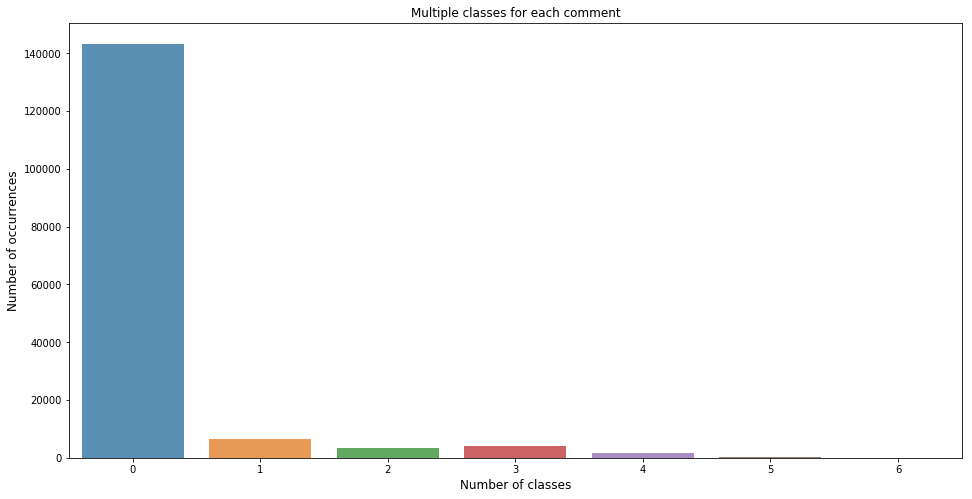

In [8]:
temp = x_train.loc[:,list_classes].sum(axis=1).value_counts()
plt.figure(figsize=(16,8))
ax = sns.barplot(temp.index, temp.values, alpha=0.8)
plt.title('Multiple classes for each comment')
plt.ylabel('Number of occurrences', fontsize=12)
plt.xlabel('Number of classes', fontsize=12)

Теперь заметно, что больше 85% комментариев вообще не имеют никакой разметки, то есть это тексты без оскорблений. А что если классы скоррелированы между собой? Давайте проверим это!

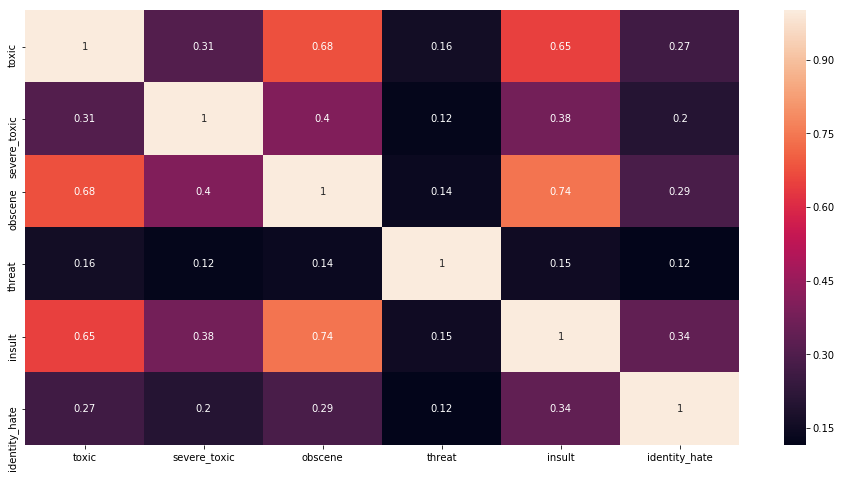

In [9]:
corr = x_train[list_classes].corr()
plt.figure(figsize = (16,8))
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, annot=True)

Однако смотерть на корелляцию Пирсона для бинарных переменных не совсем корректно. Например, здесь не отображается одна из зависимостей, которую можно найти в распределении меток между комментариями. Предложите свои варианты как это сделать более правильно.

А пока давайте обратим внимание просто на название меток для классов. Рассмотрим `severe_toxic` и просто `toxic` они имеют почти похожую смысловую нагрузку. Предлагаю посмотреть зависят ли они друг от друга?

In [10]:
crosstab = pd.crosstab(x_train['toxic'], x_train['severe_toxic'])
crosstab

severe_toxic,0,1
toxic,,
0,144277,0
1,13699,1595


Зависимость видна сразу, если у объекта класс toxic == 0, то severe_toxic не может быть равным 1

После того, как мы получили какое-то представление о данных давайте попробуем придумать новые признаки и посмотрим на данные в разрезе новых фичей:

In [11]:
%%time 
#word count
x_train['count_word']=x_train["comment_text"].apply(lambda x: len(str(x).split()))
#Unique word count
x_train['count_unique_word']=x_train["comment_text"].apply(lambda x: len(set(str(x).split())))
#Word count percent in each comment:
x_train['word_unique_percent']=x_train['count_unique_word']*100/x_train['count_word']
#derived features


CPU times: user 3.26 s, sys: 71.2 ms, total: 3.33 s
Wall time: 4.33 s


Давайте посмотрим на те комментарии, у которых количество уникальных слов удивительно мало:

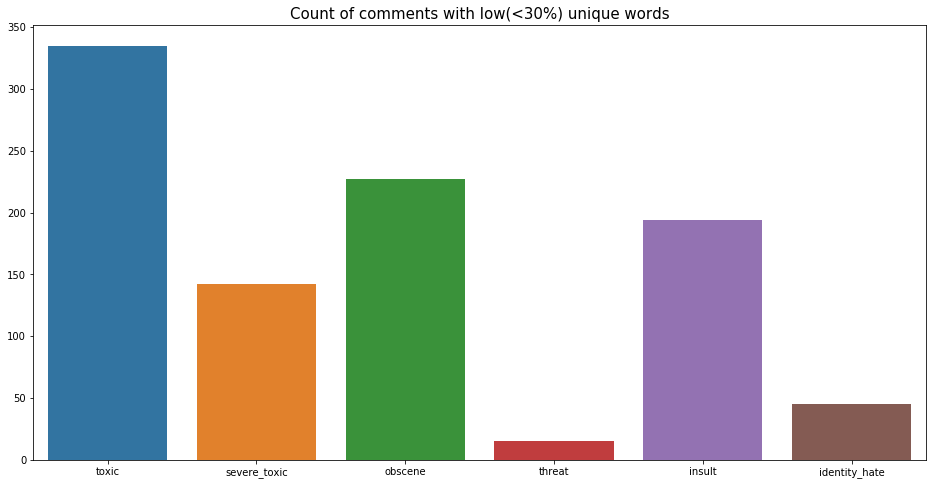

In [12]:
plt.figure(figsize = (16, 8))
temp = x_train.loc[x_train['word_unique_percent'] <= 30, list_classes].sum()
plt.title("Count of comments with low(<30%) unique words",fontsize=15)
ax=sns.barplot(x = temp.index, y = temp.values)

Сразу стало видно, что комментарии с маленьким количество слов более "токсичны", вероятнее всего они принадлежат спамерам. Чтобы это проверить предлагаю просмотреть несколько объектов руками

In [13]:
x_train.loc[x_train['word_unique_percent'] <= 30, 'comment_text'][1:3].values

array(['YOUR ARE FUCKING GAY WAD!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! \n\nI fucked your mum. OH WAIT YOUR GAY YOU DONT HAVE A MOM!!! HAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHA\nLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOL\nCUNTCUNTCUNTCUNTCUNTCUNTCUNTCUNTCUNTCUNTCUNTCUNTCUNTCUNTCUNTCUNTCUNTCUNTCUNTCUNTCUNTCUNTCUNTCUNTCUNTCUNTCUNTCUNTCUNTCUNTCUNTCUNTCUNTCUNTCUNTCUNTCUNTCUNTCUNTCUNTCUNTCUNTCUNTCUNTC

Как и ожидалось :)

Теперь давайте почистим наши данные, применим к ним tf-idf преобразование и обучим пару линейных моделей:

In [14]:
def delete_punctuation(x):
    #your code here
    
    return 

In [15]:
%%time

# приведение всех слов к нижнему регистру
#your code here

# удаление пунктуации
#your code here


CPU times: user 51.5 s, sys: 609 ms, total: 52.1 s
Wall time: 54.4 s


В качестве начального приближения давайте возьмем только униграмы и обучим логистичскую регрессию для каждого класса:

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

In [17]:
%%time

for class_ in list_classes:
    lr = LogisticRegression(max_iter=10)
    y = x_train[class_]
    X_train, X_val, y_train, y_val = train_test_split(x_train, y, test_size=0.2, random_state=123)
    tfv = TfidfVectorizer(min_df=200,  max_features=10000, 
            analyzer='word',ngram_range=(1,1))
    train_tfidf = tfv.fit_transform(X_train['comment_text'])
    val_tfidf = tfv.transform(X_val['comment_text'])
    lr.fit(train_tfidf, y_train)
    y_pred = lr.predict_proba(val_tfidf)[:, 1]
    print('Roc-auc score for {0} class: {1}'.format(class_, roc_auc_score(y_val, y_pred)))

Roc-auc score for toxic class: 0.9541343718109541
Roc-auc score for severe_toxic class: 0.979158826909654
Roc-auc score for obscene class: 0.9672149874616256
Roc-auc score for threat class: 0.985928496415359
Roc-auc score for insult class: 0.9660461925515808
Roc-auc score for identity_hate class: 0.9413903971895059
CPU times: user 1min 11s, sys: 2.68 s, total: 1min 14s
Wall time: 1min 17s


### Очумелые ручки

In [18]:
Image(url= "http://img.lady.ru/data/aphoto/e/4/6/47344/main/8d9fc99b290516b808522fdcd3474e75.jpg")

Пришло время написать код самим, давайте попробуем улучшить результат!

#### Задание 1. Чистим текст еще больше

Попробуйте почистить тексты еще лучше, что вы можете предложить?


Hints: удалите смайлики, лемматизируйте слова, уберите стоп слова

In [19]:
#your code here

#### Задание 2. И снова tf-idf

Примените tf-idf преобразование заново, но теперь используйте не только униграммы, но также биграммы и триграммы.

In [20]:
#your code here

#### Задание 3. Немного фантазии

Какие способы представления текста вы еще можете предложить? Как можно использовать tf-idf еще? 

Hints: CountVectorizer, tf-idf char level

In [21]:
#your code here

#### Задание 4. Новые признаки

Придумайте новые признаки для описания текста


In [22]:
#your code here

#### Задание 5. Объединение работы

Объедините все придуманные признаки в одну матрицу с tf-idf(char and word level), обучите логистическую регрессию с L1 регуляризацией, отберите признаки(можно воспользоваться `lr.coef_`) и обучите снова, стало ли лучше? Сравните с качеством на униграммах.

In [23]:
#your code here

#### Задание 6. Визуализация

Визуализируйте топ-10 признаков для каждого класса. Есть ли какая-то закономерность?